In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

matplotlib.rc("axes", **{"spines.top": False, "spines.right": False})
matplotlib.rc("legend", frameon=False)

In [2]:
df_raw = pd.read_json("../results/measure_speed.jsonl", lines=True)

In [3]:
df_raw.method.apply(lambda s: re.sub(r"(^\.+)|(\.+$)", "", re.sub(r"\b(approx_topk|exact_methods|topk|__main__)\b", "", s))).unique()

array(['fake_topk_sum', 'torch_default', 'radix_select',
       'bucket_argmax.topk_autobucket', 'bucket_argmax.topk_torch',
       'bucket_argmax.topk_triton'], dtype=object)

In [4]:
df = (pd.read_json("../results/measure_speed.jsonl", lines=True)
    .pipe(lambda d: d.assign(
        compile=d.compile.apply(str),
        method=d.method.apply(lambda s: re.sub(r"(^\.+)|(\.+$)", "", re.sub(r"\b(approx_topk|exact_methods|topk|__main__)\b", "", s))),
        duration=d.duration.apply(np.mean) / d.n_inner,
        duration_stderr=d.duration.apply(lambda d: np.std(d)/np.sqrt(len(d))) / d.n_inner,
    ))
    .pipe(lambda d: d.assign(
        bandwidth=d.dtype.apply(dict(float32=4, float16=2).__getitem__) * d.topk_size * d.batch_size / d.duration,
    ))
)
df.head()

,compile,batch_size,topk_size,k,n_warmup,n_outer,n_inner,method,dtype,duration,device,block_size,duration_stderr,bandwidth
0,None,32,4096,512,16,16,128,fake_topk_sum,float32,0.000025,NVIDIA A10G,NaN,4.949886e-08,2.123611e+10
1,None,32,16384,2048,16,16,128,fake_topk_sum,float32,0.000021,NVIDIA A10G,NaN,4.267966e-08,9.927105e+10
2,None,32,65536,8192,16,16,128,fake_topk_sum,float32,0.000023,NVIDIA A10G,NaN,1.004995e-08,3.648490e+11
3,None,32,4096,512,16,16,128,torch_default,float32,0.000037,NVIDIA A10G,NaN,3.309390e-08,1.434087e+10
4,None,32,16384,2048,16,16,128,torch_default,float32,0.000072,NVIDIA A10G,NaN,4.609488e-08,2.906595e+10


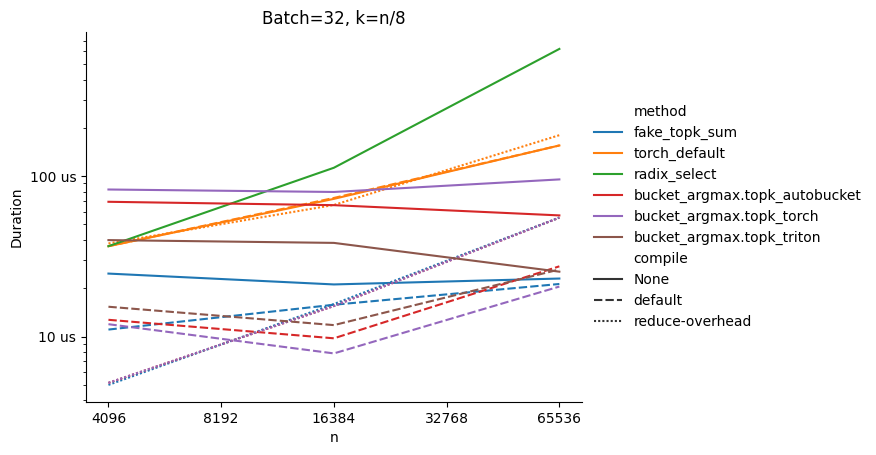

In [5]:
ax = sns.lineplot(data=df, y="duration", x="topk_size", hue="method", style="compile")
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
ax.set_yscale("log")
ax.yaxis.set_major_formatter(lambda x, _: f"{x*1e6:.0f} us")
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter("{x:.0f}")
ax.set_xlabel("n")
ax.set_ylabel("Duration")
ax.set_title("Batch=32, k=n/8");

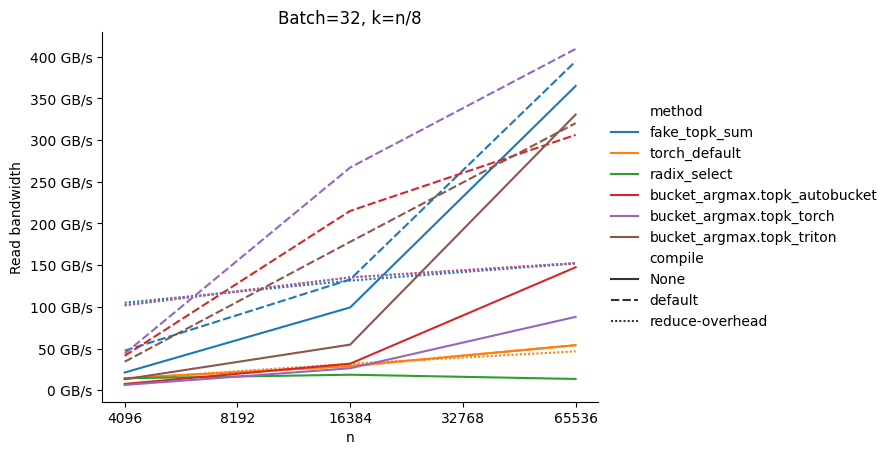

In [6]:
ax = sns.lineplot(data=df, y="bandwidth", x="topk_size", hue="method", style="compile")
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter("{x:.0f}")
ax.set_xlabel("n")
ax.set_ylabel("Read bandwidth")
ax.set_title("Batch=32, k=n/8");